

## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [ ]:
!pip install -U torch torchvision

In [ ]:
# установка подходящей версии torch

from os.path import exists
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
# cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
# accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [ ]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
# !pip uninstall -y Pillow
# !pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перехгрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

7.1.2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q "/content/gdrive/MyDrive/DLSchool/Домашние задания/14.1 Домашнее задание/journey-springfield/dataset.zip" -d train
!unzip -q "/content/gdrive/MyDrive/DLSchool/Домашние задания/14.1 Домашнее задание/journey-springfield/testset.zip" -d test

In [ ]:
!ls tets

ls: cannot access 'tets': No such file or directory


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Wed Dec  1 15:43:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, datasets
import torch.optim as optim
from torch.optim import lr_scheduler
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()
        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels) # transform
            # print(self.label_encoder.classes_)
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            # print(x, y)
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('/content/train/train')
TEST_DIR = Path('/content/test/val')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

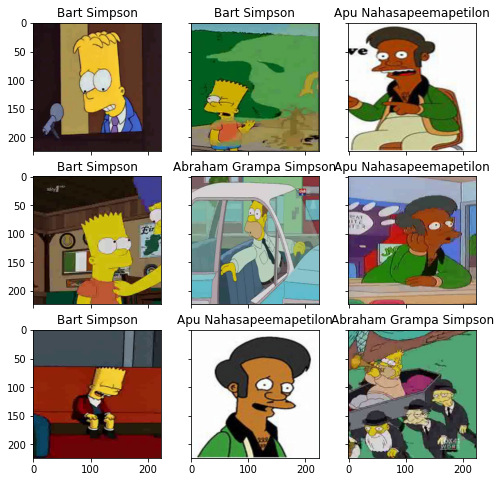

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [ ]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

# Tag

Запустим обучение сети.

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='test')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 2.584148522455743


epoch:  50%|█████     | 1/2 [02:09<02:09, 129.28s/it]


Epoch 001 train_loss: 2.5841     val_loss 1.9923 train_acc 0.2868 val_acc 0.4530
loss 1.6240709760749603


epoch: 100%|██████████| 2/2 [04:17<00:00, 128.62s/it]


Epoch 002 train_loss: 1.6241     val_loss 1.4388 train_acc 0.5527 val_acc 0.6116


Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

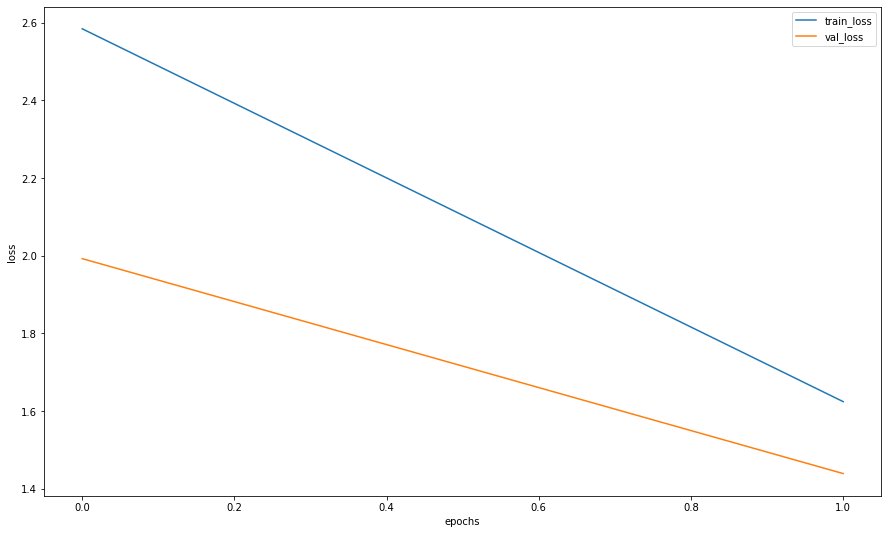

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average="weighted")

0.7839285714285714

In [ ]:
np.argmax(probs_ims,-1)

array([ 7,  4,  0,  0,  2,  6,  4,  6,  2,  4,  0,  0,  4, 36, 15,  4,  2,
        4, 28,  2])

In [ ]:
label_encoder.classes_

array(['abraham_grampa_simpson', 'agnes_skinner',
       'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson',
       'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum',
       'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel',
       'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson',
       'kent_brockman', 'krusty_the_clown', 'lenny_leonard',
       'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson',
       'martin_prince', 'mayor_quimby', 'milhouse_van_houten',
       'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz',
       'otto_mann', 'patty_bouvier', 'principal_skinner',
       'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum',
       'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird',
       'troy_mcclure', 'waylon_smithers'], dtype='<U24')

In [ ]:
preds_class

['chief_wiggum',
 'bart_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'apu_nahasapeemapetilon',
 'charles_montgomery_burns',
 'bart_simpson',
 'charles_montgomery_burns',
 'apu_nahasapeemapetilon',
 'bart_simpson',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'bart_simpson',
 'selma_bouvier',
 'homer_simpson',
 'bart_simpson',
 'apu_nahasapeemapetilon',
 'bart_simpson',
 'ned_flanders',
 'apu_nahasapeemapetilon']

In [ ]:
actual_labels

[6, 4, 0, 0, 2, 6, 4, 6, 2, 4, 0, 0, 4, 6, 3, 4, 2, 4, 2, 2]

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

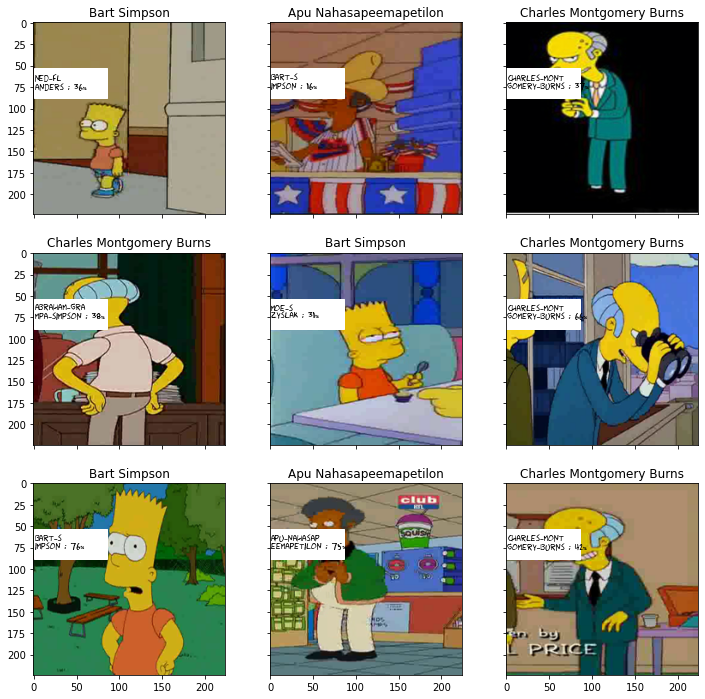

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls 

gdrive	label_encoder.pkl  sample_data	test  train


In [ ]:
import pandas as pd
# my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [ ]:
my_submit.to_csv('/content/gdrive/MyDrive/DLSchool/Домашние задания/14.1 Домашнее задание/simple_cnn_baseline.csv', index=False)

# Tag


In [ ]:
pd.read_csv('/content/gdrive/MyDrive/DLSchool/Домашние задания/14.1 Домашнее задание/simple_cnn_baseline.csv')

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,nelson_muntz
987,img988.jpg,marge_simpson
988,img989.jpg,charles_montgomery_burns
989,img99.jpg,chief_wiggum


## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


# MyNN

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

## Alexnet

In [ ]:
"""Импортируем модель model Alexnet"""
from torchvision import models, transforms
model_alexnet = models.alexnet(pretrained=True).to(DEVICE)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
"""Посмотрим что внутри"""
model_alexnet

NameError: ignored

In [ ]:
n_classes = len(np.unique(train_val_labels))

In [ ]:
n_classes

42

In [ ]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# n_classes -- это количесвто классов 
# Заменяем Fully-Connected слой на наш линейный классификатор
model_alexnet.classifier = nn.Linear(num_features, n_classes).to(DEVICE)


## Fine Tuning способ

  **берем CNN, которую можно дообучить (Fine Tuning)**  
  * Берём сетку, обученную на ImageNet  
  * Убираем последние Fully-Connected слои сети, отвечающие за классификацию.  
  * Теперь всё же *распространяем backpropagation* ещё на сколько-то слоёв назад (размораживаем веса в этих слоях)*, чтобы скорректировать их под новые данные. Можно распространить обучение и на всю сеть, но часто первые слои всё же замораживают, поскольку они (как ожидается) извлекают более общие признаки. А ещё обучать всю сеть всё же дольше, чем несколько слоёв. Всё зависит от того, какого качества Вы хотите добиться
  * Теперь сеть выдаёт не метки классов, а то, что поступало на вход Fully-Connected (веса последних (или всех) слоёв были изменены под наши данные)
  * Обучаем на этих признаках какой-либо классификатор (свою Fully-Connected сеть, например)
  * Теперь у нас есть сеть, работающая хорошо на нашем датасете



In [ ]:
"""Запустим обучение с AlexNet"""
history = train(train_dataset, val_dataset, model=model_alexnet, epochs=5, batch_size=64)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 2.401799960526412


epoch:  20%|██        | 1/5 [02:09<08:39, 129.87s/it]


Epoch 001 train_loss: 2.4018     val_loss 1.5916 train_acc 0.3293 val_acc 0.5818
loss 1.1896143468506541


epoch:  40%|████      | 2/5 [04:19<06:28, 129.61s/it]


Epoch 002 train_loss: 1.1896     val_loss 0.9272 train_acc 0.6790 val_acc 0.7465
loss 0.7655814194559284


epoch:  60%|██████    | 3/5 [06:28<04:19, 129.62s/it]


Epoch 003 train_loss: 0.7656     val_loss 0.8137 train_acc 0.7933 val_acc 0.7875
loss 0.5476221993031172


epoch:  80%|████████  | 4/5 [08:38<02:09, 129.61s/it]


Epoch 004 train_loss: 0.5476     val_loss 0.8140 train_acc 0.8513 val_acc 0.8063
loss 0.39728098458385225


epoch: 100%|██████████| 5/5 [10:48<00:00, 129.63s/it]


Epoch 005 train_loss: 0.3973     val_loss 0.7951 train_acc 0.8881 val_acc 0.8170


In [ ]:
# random_characters = int(np.random.uniform(0,1000))
# ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_alexnet, ex_img.unsqueeze(0))

# idxs = list(map(int, np.random.uniform(0,1000, 20)))
# imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_alexnet, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]
f1_score(actual_labels, y_pred, average="weighted")

0.9214285714285715

## submit Alexnet

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_alexnet, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

# my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

NameError: ignored

In [ ]:
my_submit.to_csv('/content/gdrive/MyDrive/DLSchool/Домашние задания/14.1 Домашнее задание/model_alexnet.csv', index=False)

In [ ]:
pd.read_csv('/content/gdrive/MyDrive/DLSchool/Домашние задания/14.1 Домашнее задание/model_alexnet.csv')

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
986,img987.jpg,nelson_muntz
987,img988.jpg,marge_simpson
988,img989.jpg,charles_montgomery_burns
989,img99.jpg,chief_wiggum


score on the Kaggle 0.90329

## Feature Extractor способ:

In [ ]:
model_extractor = models.alexnet(pretrained=True).to(DEVICE)

In [ ]:
for param in model_extractor.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


Сделаем так, чтобы на них не распространялся backpropagation (заморозим их), и подменим классификатор (ведь старый уже с весами для ImageNet'а).

In [ ]:
# замораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# n_classes -- это количесвто классов 
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.classifier = nn.Linear(num_features, n_classes).to(DEVICE)

In [ ]:
"""Запустим AlexNet c заморозкой всех слоев"""
history = train(train_dataset, val_dataset, model=model_extractor, epochs=5, batch_size=64)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 1.7971074164874297


epoch:  20%|██        | 1/5 [02:09<08:38, 129.56s/it]


Epoch 001 train_loss: 1.7971     val_loss 1.2307 train_acc 0.6597 val_acc 0.7520
loss 0.36217752152570865


epoch:  40%|████      | 2/5 [04:18<06:27, 129.25s/it]


Epoch 002 train_loss: 0.3622     val_loss 1.2912 train_acc 0.8999 val_acc 0.7646
loss 0.16564919754527724


epoch:  60%|██████    | 3/5 [06:25<04:16, 128.26s/it]


Epoch 003 train_loss: 0.1656     val_loss 1.3511 train_acc 0.9510 val_acc 0.7782
loss 0.07910855931679385


epoch:  80%|████████  | 4/5 [08:33<02:07, 127.93s/it]


Epoch 004 train_loss: 0.0791     val_loss 1.2063 train_acc 0.9756 val_acc 0.8099
loss 0.04016765538173327


epoch: 100%|██████████| 5/5 [10:39<00:00, 127.98s/it]


Epoch 005 train_loss: 0.0402     val_loss 1.3216 train_acc 0.9885 val_acc 0.7952


In [ ]:
# random_characters = int(np.random.uniform(0,1000))
# ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_extractor, ex_img.unsqueeze(0))

# idxs = list(map(int, np.random.uniform(0,1000, 20)))
# imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_extractor, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]
f1_score(actual_labels, y_pred, average="weighted")

0.8370129870129869

## Смешанный способ: Мы будем обучать не только последний fully connected слой, но и несколько предпоследних

Перед тем как использовать смешанный способ мы должны переопределить параметры в оптимизаторе Aam.

In [ ]:
def train(train_files, val_files, model, epochs, batch_size, opt=False):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        if opt == False:
          print("opt no add")
          opt = torch.optim.Adam(model.parameters()) # доработка оптимизатора
        criterion = nn.CrossEntropyLoss()
        
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
model_mixed = models.alexnet(pretrained=True).to(DEVICE)

In [ ]:
layers_to_unfreeze = 5
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_mixed.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False
# parameters() возвращает просто список тензоров парамтеров, поэтому два таких списка можно сложить
optimizer = optim.Adam(list(model_mixed.features.parameters())[-layers_to_unfreeze:] + 
                      list(model_mixed.classifier.parameters()))

In [ ]:
model_mixed.classifier = nn.Linear(num_features, n_classes).to(DEVICE)

In [ ]:
for param in model_mixed.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
True
True
True
True
True
True


In [ ]:
"""Запустим AlexNet c заморозкой 5 первых слоев"""
history = train(train_dataset, val_dataset, model=model_mixed, epochs=5, batch_size=64, opt=optimizer)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 1.5097921701880563


epoch:  20%|██        | 1/5 [02:07<08:30, 127.53s/it]


Epoch 001 train_loss: 1.5098     val_loss 0.8107 train_acc 0.6155 val_acc 0.7944
loss 0.3696995414957225


epoch:  40%|████      | 2/5 [04:15<06:22, 127.64s/it]


Epoch 002 train_loss: 0.3697     val_loss 0.6741 train_acc 0.9095 val_acc 0.8261
loss 0.06570453936198166


epoch:  60%|██████    | 3/5 [06:26<04:18, 129.12s/it]


Epoch 003 train_loss: 0.0657     val_loss 0.6504 train_acc 0.9862 val_acc 0.8491
loss 0.018978426741249017


epoch:  80%|████████  | 4/5 [08:39<02:10, 130.79s/it]


Epoch 004 train_loss: 0.0190     val_loss 0.6034 train_acc 0.9986 val_acc 0.8678
loss 0.00655059268767594


epoch: 100%|██████████| 5/5 [10:52<00:00, 130.54s/it]


Epoch 005 train_loss: 0.0066     val_loss 0.6175 train_acc 0.9997 val_acc 0.8638


In [ ]:
# random_characters = int(np.random.uniform(0,1000))
# ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_mixed, ex_img.unsqueeze(0))

# idxs = list(map(int, np.random.uniform(0,1000, 20)))
# imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_mixed, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]
f1_score(actual_labels, y_pred, average="weighted")

0.8655844155844156

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_mixed, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

# my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('/content/gdrive/MyDrive/DLSchool/Домашние задания/14.1 Домашнее задание/model_alexnet_mixed.csv', index=False)

## VGG16

In [ ]:
model_vgg16 = models.vgg16(pretrained=True).to(DEVICE)

# замораживаем параметры (веса)
# for param in model_extractor.parameters():
    # param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
# Заменяем Fully-Connected слой на наш линейный классификатор
model_vgg16.classifier = nn.Linear(num_features, n_classes).to(DEVICE)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
model_vgg16.load_state_dict(torch.load('/content/gdrive/MyDrive/DLSchool/Домашние задания/14.1 Домашнее задание/model_vgg16_fine_tune.pth'))

<All keys matched successfully>

In [ ]:
for param in model_vgg16.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
"""Запустим VGG16"""
history = train(train_dataset, val_dataset, model=model_vgg16, epochs=3, batch_size=32)

epoch:   0%|          | 0/3 [00:00<?, ?it/s]

loss 2.783817103064146


epoch:  33%|███▎      | 1/3 [05:10<10:21, 310.83s/it]


Epoch 001 train_loss: 2.7838     val_loss 2.1975 train_acc 0.2256 val_acc 0.3907
loss 1.8436020683487462


epoch:  67%|██████▋   | 2/3 [09:18<04:33, 273.58s/it]


Epoch 002 train_loss: 1.8436     val_loss 1.3209 train_acc 0.4979 val_acc 0.6360
loss 1.1167893309153996


epoch: 100%|██████████| 3/3 [13:43<00:00, 274.62s/it]


Epoch 003 train_loss: 1.1168     val_loss 1.0590 train_acc 0.7041 val_acc 0.7016


In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_vgg16, ex_img.unsqueeze(0))

idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_vgg16, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]
f1_score(actual_labels, y_pred, average="weighted")

0.767919799498747

In [ ]:
"""Запустим VGG16 c несколльких слоев"""
model_vgg16_mixed = models.vgg16(pretrained=True).to(DEVICE)
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
layers_to_unfreeze = 10

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_vgg16_mixed.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

# parameters() возвращает просто список тензоров парамтеров, поэтому два таких списка можно сложить
optimizer = optim.Adam(list(model_vgg16_mixed.features.parameters())[-layers_to_unfreeze:] + 
                      list(model_vgg16_mixed.classifier.parameters()))


In [ ]:
model_vgg16_mixed.classifier = nn.Linear(num_features, n_classes).to(DEVICE)

In [ ]:
for param in model_vgg16_mixed.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True


In [ ]:
"""Запустим VGG16 c заморозкой 5 первых слоев"""
history = train(train_dataset, val_dataset, model=model_vgg16_mixed, epochs=3, batch_size=32, opt=optimizer)

epoch:   0%|          | 0/3 [00:00<?, ?it/s]

loss 1.3364203135537012


epoch:  33%|███▎      | 1/3 [03:14<06:29, 194.87s/it]


Epoch 001 train_loss: 1.3364     val_loss 1.0868 train_acc 0.6630 val_acc 0.7747
loss 0.5158591248539726


epoch:  67%|██████▋   | 2/3 [06:46<03:24, 204.71s/it]


Epoch 002 train_loss: 0.5159     val_loss 0.5370 train_acc 0.8771 val_acc 0.8735
loss 0.3275685391689427


epoch: 100%|██████████| 3/3 [10:18<00:00, 206.05s/it]


Epoch 003 train_loss: 0.3276     val_loss 0.5849 train_acc 0.9190 val_acc 0.8800


In [ ]:
# random_characters = int(np.random.uniform(0,1000))
# ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_vgg16_mixed, ex_img.unsqueeze(0))

# idxs = list(map(int, np.random.uniform(0,1000, 20)))
# imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_vgg16_mixed, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]
f1_score(actual_labels, y_pred, average="weighted")

0.95

* 0.973 при 5 размороженных слоях.
* 1.0 при 10 размороженных слоях на kaggle показала 85, что говорит о переобучении.

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_vgg16_mixed, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

# my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('/content/gdrive/MyDrive/DLSchool/Домашние задания/14.1 Домашнее задание/model_vgg16_mixed.csv', index=False)

In [ ]:
model_vgg16_extr = models.vgg16(pretrained=True).to(DEVICE)

# замораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
# Заменяем Fully-Connected слой на наш линейный классификатор
model_vgg16_extr.classifier = nn.Linear(num_features, n_classes).to(DEVICE)

In [ ]:
"""Запустим VGG16"""
history = train(train_dataset, val_dataset, model=model_vgg16_extr, epochs=3, batch_size=32)

In [ ]:
# random_characters = int(np.random.uniform(0,1000))
# ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_vgg16_extr, ex_img.unsqueeze(0))

# idxs = list(map(int, np.random.uniform(0,1000, 20)))
# imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_vgg16_extr, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]
f1_score(actual_labels, y_pred, average="weighted")

## Submit VGG16 etxr

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_extractor, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
# my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

In [ ]:
my_submit.to_csv('/content/gdrive/MyDrive/DLSchool/Домашние задания/14.1 Домашнее задание/VGG16.csv', index=False)

# Inception

In [ ]:
model_inception = models.inception_v3(pretrained=True).to(DEVICE)

In [ ]:
model_inception.Conv2d_1a_3x3( )

In [ ]:
model_inception.AuxLogits.fc = nn.Linear(768, 42)
model_inception.fc = nn.Linear(2048, 42)

In [ ]:
model_inception.classifier = nn.Linear(num_features, 42)

In [ ]:
# Обучаем только классификатор
optimizer = optim.Adam(model_inception.parameters(), lr=1e-4)
model_inception.aux_logits = False
history = train(train_dataset, val_dataset, model=model_inception, epochs=3, batch_size=32, opt=optimizer)

# EfficientNet

In [ ]:
 model_extractor = models.efficientnet_b6(pretrained=True).to(DEVICE)

In [ ]:
model_extractor

In [ ]:
# замораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 2304
# Заменяем Fully-Connected слой на наш линейный классификатор
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.classifier = nn.Linear(num_features, n_classes).to(DEVICE)

In [ ]:
"""Запустим EfficientNet c заморозкой всех слоев"""
history = train(train_dataset, val_dataset, model=model_extractor, epochs=5, batch_size=128)

In [ ]:
# random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_extractor, ex_img.unsqueeze(0))

# idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_extractor, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]
f1_score(actual_labels, y_pred, average="weighted")